# Import libraries

In [42]:
import nltk
from nltk.tokenize import word_tokenize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import os
import time
import warnings
import random
import string
from collections import Counter
from PIL import Image


sns.set_context("paper")
sns.set_style("whitegrid")

warnings.filterwarnings('ignore')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
ROOT = '/kaggle/input/food-vqa/VN20-500_v3'
# ROOT = '/kaggle/input/hand-image-vqa'


train_df = pd.read_csv(f'{ROOT}/annotations/train.csv')
val_df = pd.read_csv(f'{ROOT}/annotations/validation.csv')
test_df = pd.read_csv(f'{ROOT}/annotations/test.csv')

In [44]:
def clean_text(text):
    if isinstance(text, str):  # Kiểm tra nếu text là chuỗi
        return ''.join(c for c in text if c not in string.punctuation).lower()
    return text  # Nếu không phải chuỗi, giữ nguyên

# Hàm tiền xử lý từng dòng
def preprocess(row):
    row["question"] = clean_text(row["question"])
    row["answer"] = clean_text(row["answer"])

    return row

# Load DataFrame (giả sử bạn đã có train_df, val_df, test_df)
train_df = train_df.apply(preprocess, axis=1).dropna().reset_index(drop=True)
val_df = val_df.apply(preprocess, axis=1).dropna().reset_index(drop=True)
test_df = test_df.apply(preprocess, axis=1).dropna().reset_index(drop=True)

data =  pd.concat([train_df, val_df, test_df], ignore_index=True)

# Kiểm tra số lượng mẫu sau tiền xử lý
print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")


Train samples: 41613, Val samples: 4839, Test samples: 10879


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57331 entries, 0 to 57330
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question       57331 non-null  object
 1   answer         57331 non-null  object
 2   question_type  57331 non-null  object
 3   answer_type    57331 non-null  object
 4   image_path     57331 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


In [46]:
data.describe()

,question,answer,question_type,answer_type,image_path
count,57331,57331,57331,57331,57331
unique,3193,27,3,2,9514
top,có nước chấm đi kèm không,có,yes/no,text,train/Banh_Beo/10.jpg
freq,2074,22165,23620,32309,14


In [47]:
data.answer.unique()

array(['bánh bèo', 'có', 'trắng', 'vàng', 'đỏ', 'đúng', 'không', 'nâu',
       'bánh căn', 'bánh giò', 'bánh mì', 'bánh tráng nướng', 'bánh xèo',
       'bắp xào', 'bún bò', 'bún chả', 'bún đậu', 'bún mắm',
       'bún thịt nướng', 'cao lầu', 'cháo lòng', 'cơm tấm', 'gỏi cuốn',
       'hủ tiếu', 'mì quảng', 'phở', 'phá lấu'], dtype=object)

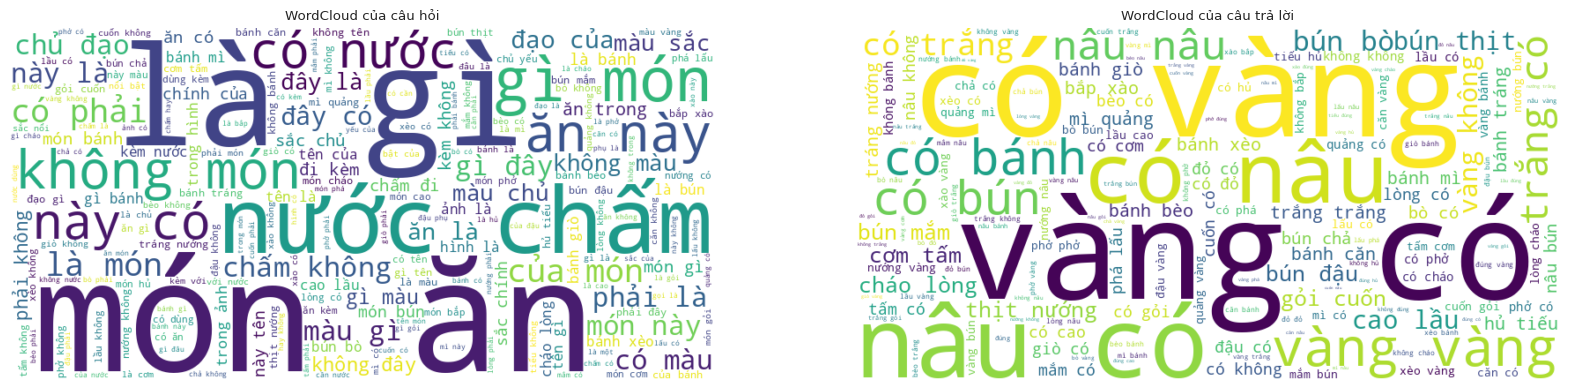

In [48]:
questions = " ".join(data['question'].dropna())
answers = " ".join(data['answer'].dropna())

question_cloud = WordCloud(width=800, height=400, background_color='white').generate(questions)
answer_cloud = WordCloud(width=800, height=400, background_color='white').generate(answers)

fig, axes = plt.subplots(1, 2, figsize=(20, 20))

axes[0].imshow(question_cloud, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("WordCloud của câu hỏi")

axes[1].imshow(answer_cloud, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("WordCloud của câu trả lời")

plt.show()

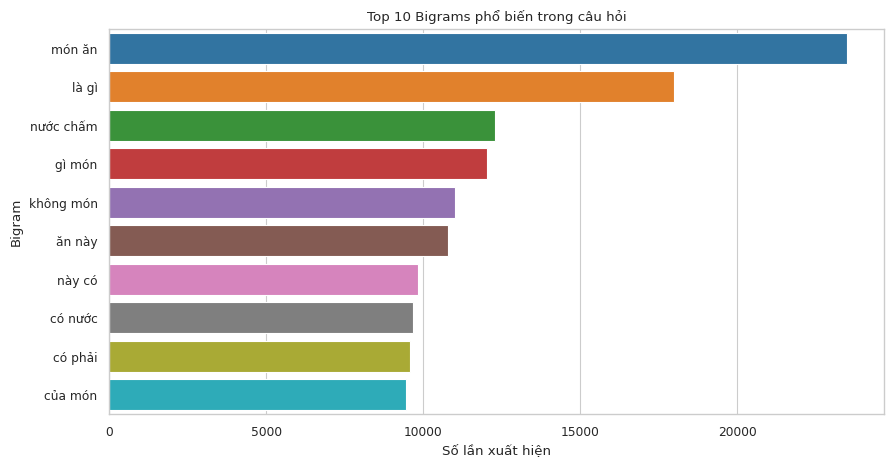

In [49]:
if not data['question'].dropna().empty:
    all_words = [word for sentence in data['question'].dropna() for word in word_tokenize(sentence.lower())]
    bigrams = list(nltk.bigrams(all_words))

    if bigrams:
        bigram_counts = Counter(bigrams).most_common(10)
        bigram_labels, bigram_values = zip(*bigram_counts)
        bigram_labels = [" ".join(b) for b in bigram_labels]

        plt.figure(figsize=(10, 5))
        sns.barplot(x=list(bigram_values), y=bigram_labels)
        plt.title("Top 10 Bigrams phổ biến trong câu hỏi")
        plt.xlabel("Số lần xuất hiện")
        plt.ylabel("Bigram")
        plt.show()

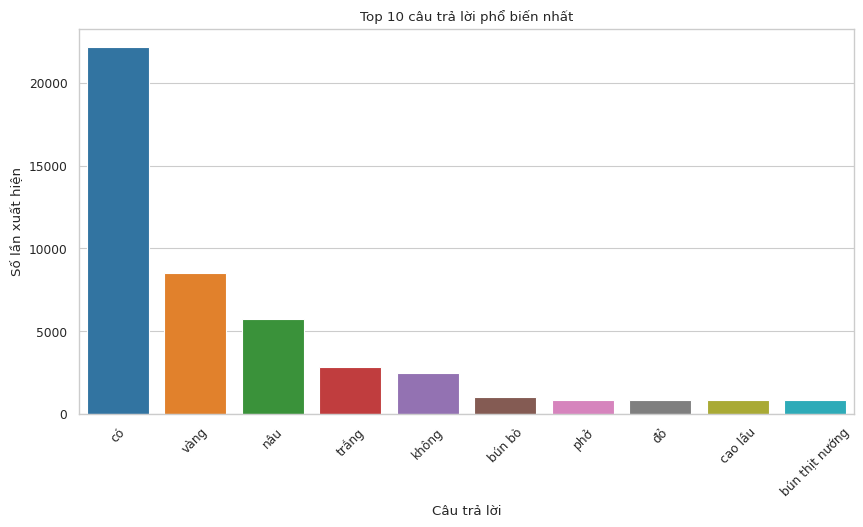

In [50]:
top_answers = data['answer'].value_counts().nlargest(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_answers.index, y=top_answers.values)
plt.xticks(rotation=45)
plt.title("Top 10 câu trả lời phổ biến nhất")
plt.xlabel("Câu trả lời")
plt.ylabel("Số lần xuất hiện")
plt.show()


# Data preprocessing

In [51]:
def process_answer(text):
    text = text.replace(',', '').lower()
    return '_'.join(text.split(' '))

In [52]:
def read_txt_to_list(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.read().splitlines()  # Loại bỏ ký tự xuống dòng '\n'
    return lines

questions = data.question
answers = data.answer.apply(lambda x: '_'.join(x.split(' '))).unique()

# questions = map(process_answer, questions)


In [53]:
class Vocab():
    def __init__(self, texts, pad_token='<pad>', unk_token='<unk>', pad_idx=0, unk_idx=1):
        self.PAD_TOKEN = pad_token
        self.UNK_TOKEN = unk_token
        self.PAD_IDX = pad_idx
        self.UNK_IDX = unk_idx
        
        self.vocab = self._build_vocab(texts)
        self.vocab2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.size = len(self.vocab)

    def word2idx(self, vocab):
        if vocab in self.vocab2idx:
            return self.vocab2idx[vocab]
        else:
            return self.vocab2idx[self.UNK_TOKEN]

    def idx2word(self, idx):
        return self.vocab[idx]

    def _build_vocab(self, texts, min_freq=1):
        counter = Counter()
        for text in texts:
            tokens = word_tokenize(text.lower())
            counter.update(tokens)
    
        vocab = [self.PAD_TOKEN, self.UNK_TOKEN]  
        for word, freq in counter.items():
            if freq >= min_freq: 
                vocab.append(word)
                
        return vocab

In [54]:
question_vocab = Vocab(questions)
answer_vocab = Vocab(answers)

# for i in answer_vocab.vocab:
#     token = i.split('_')

#     if len(token) > 3:
#         answer_vocab.vocab.remove(i)

len(question_vocab.vocab), len(answer_vocab.vocab)

for i in answer_vocab.vocab:
    print(i)

<pad>
<unk>
bánh_bèo
có
trắng
vàng
đỏ
đúng
không
nâu
bánh_căn
bánh_giò
bánh_mì
bánh_tráng_nướng
bánh_xèo
bắp_xào
bún_bò
bún_chả
bún_đậu
bún_mắm
bún_thịt_nướng
cao_lầu
cháo_lòng
cơm_tấm
gỏi_cuốn
hủ_tiếu
mì_quảng
phở
phá_lấu


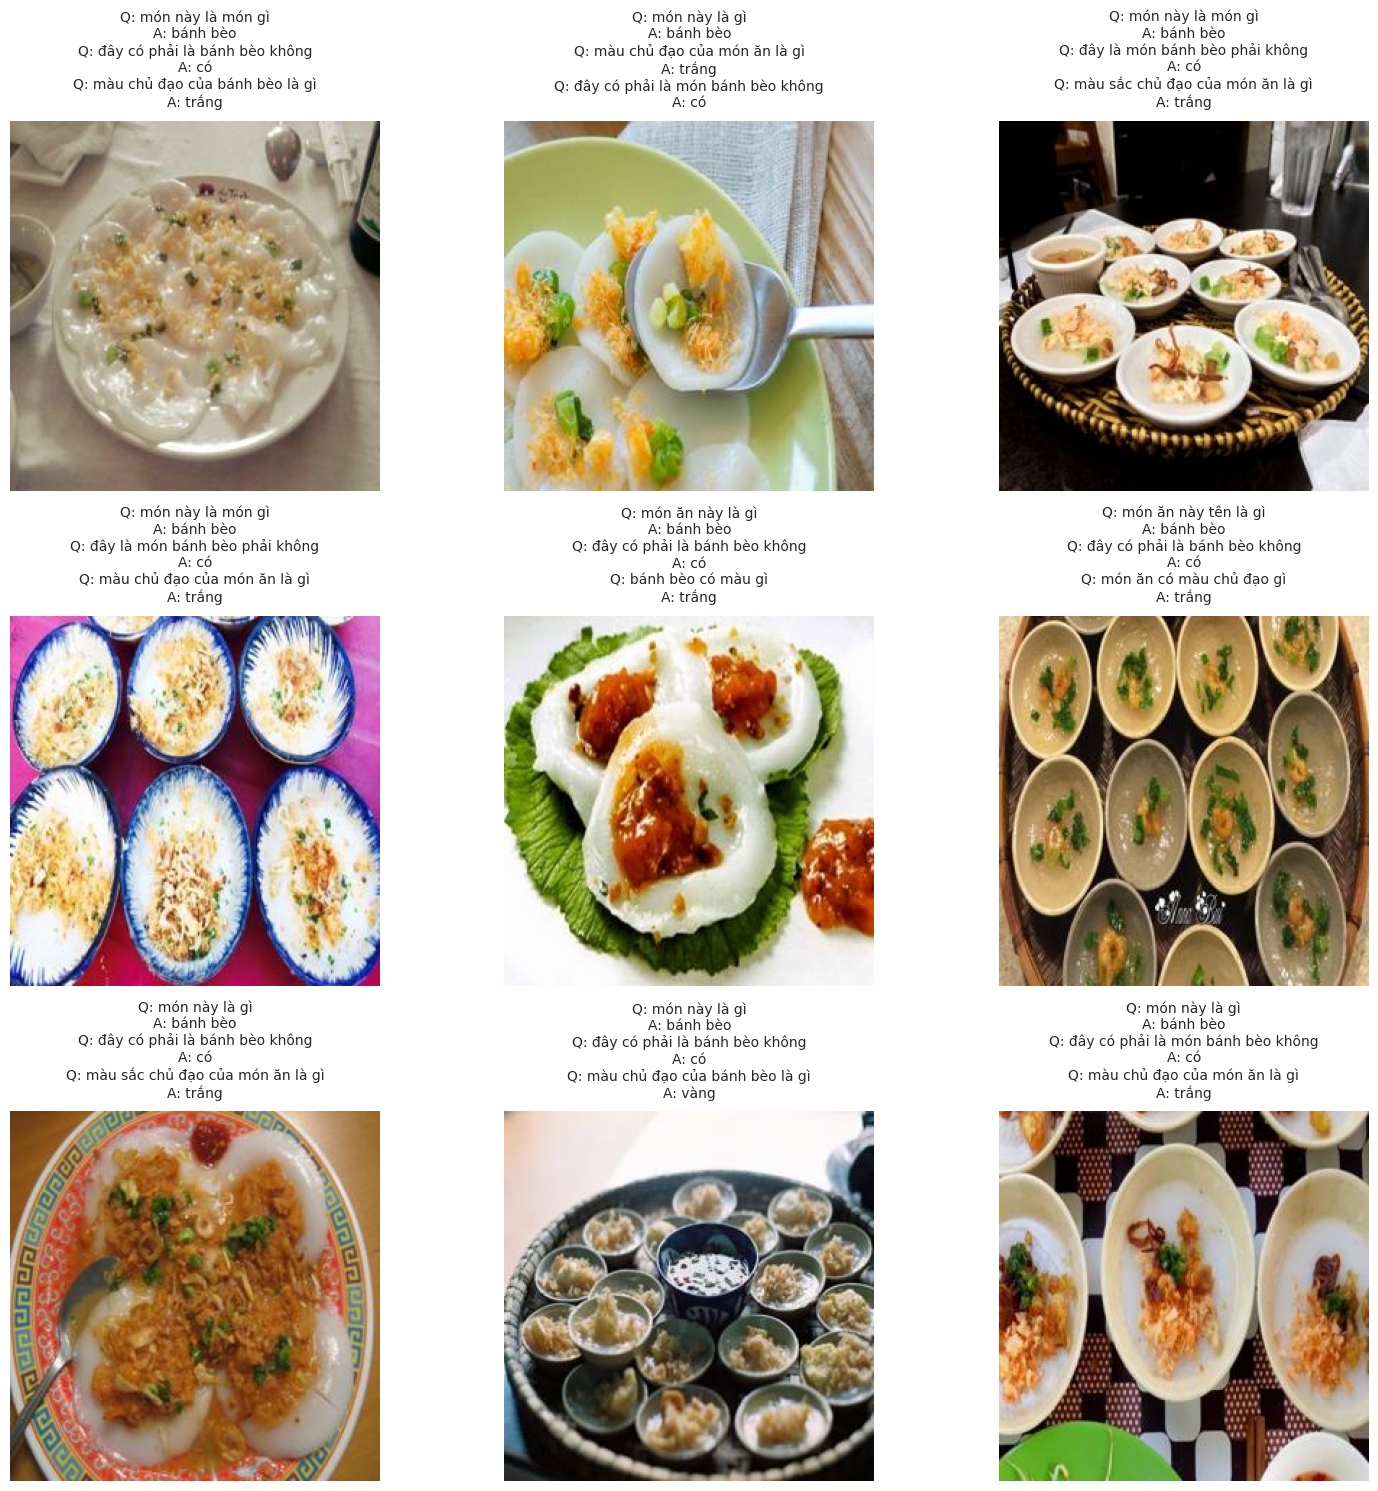

In [59]:
def show_images_with_questions(data, num_samples=9, root=f'{ROOT}/images'):
    unique_images = data["image_path"].unique()[:num_samples]  # Lấy N ảnh đầu tiên
    num_rows = num_cols = int(num_samples ** 0.5)  # Xác định số hàng và cột cho subplot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()  # Chuyển mảng 2D về 1D để dễ truy cập
    
    for idx, img_path in enumerate(unique_images):
        related_questions = data[data["image_path"] == img_path][["question", "answer"]].head(3)  # Chỉ lấy 3 câu hỏi đầu tiên
        img = Image.open(f'{root}/{img_path}')
        
        axes[idx].imshow(img)
        axes[idx].axis("off")
        
        # Ghép câu hỏi và câu trả lời thành một chuỗi ngắn gọn
        qa_text = "\n".join([f"Q: {q}\nA: {a}" for q, a in zip(related_questions['question'], related_questions['answer'])])
        axes[idx].set_title(qa_text, fontsize=10, pad=10)
    
    plt.tight_layout()
    plt.show()

# Hiển thị ảnh với câu hỏi
show_images_with_questions(train_df, num_samples=9)